# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Я предобработала данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузим данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла. 

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовлю аналитическую записку, в которой опишу:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

- Автор: Савина Юлия Сергеевнач

## Цели и задачи проекта

Необходимо выяснить, в каком городе пользователи больше читают книги на сервисе яндекс книги.После статистического теста нужно предположить причины, объянсяющие результаты.

## Описание данных
- unnamed:0 - номер записи (int64)
- city - город (object)
- puid - идентификатор пользователя (int64)
- hours - сумма часов чтения и прослушивания (float64)

## Содержимое проекта

<font color='#777778'>Перечислите основные шаги проекта или напишите оглавление. Используйте описание проекта, чтобы зафиксировать основные шаги.</font>

1. Загрузить данные и познакомиться с ними.
2. Проверить наличие дубликатов в идентификаторах пользователей
3. Сравнить размеры групп, их статистику и распределение.
4. Статистически доказать гипотезу.
5. Подготовить аналитическую записку, описав тип t-теста, уровень стат значимости, результат теста или p-value
6. Интерпретация результатов.
7. Описать возможные причины, объясняющие полученные результаты.

## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла

In [36]:
#Импортируем библиотеки и загружаем файл
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
#Загрузка данных
df = pd.read_csv('yandex_knigi_data.csv')

Данные без пропусков. Всего 8784 строки

In [39]:
#Посчитаем кол-во уникальных пользователей
print(f'Кол-во уникальных пользователей', df['puid'].nunique())
duplicates = df[df['puid'].duplicated(keep=False)].sort_values('puid')
print("Примеры дублирующихся записей:")
for puid in duplicates['puid'].unique()[:3]:
    user_data = duplicates[duplicates['puid'] == puid]
    print(f"Пользователь {puid}:")
    display(user_data[['city', 'hours']])

Кол-во уникальных пользователей 8540
Примеры дублирующихся записей:
Пользователь 2637041:


,city,hours
35,Москва,10.317371
6247,Санкт-Петербург,3.883926


Пользователь 9979490:


,city,hours
134,Москва,32.415573
6274,Санкт-Петербург,1.302997


Пользователь 10597984:


,city,hours
145,Москва,42.931506
6279,Санкт-Петербург,9.041320


Можно заметить, что записи пользователей-дубликатов появляютя в датафрейме сразу в 2 городах, это будет искажать результаты теста. Удалим их.

In [40]:
df = df.drop_duplicates(subset = ['puid'],keep = False)

In [41]:
#Создадим отдельные датафреймы для наблюдаемых групп и узнаем кол-во уникальных пользователей
df_spb = df[df['city']=='Санкт-Петербург']['hours']
df_msc = df[df['city']=='Москва']['hours']
print(f'Кол-во уникальных пользователей из города Санкт-Петербург {df_spb.nunique()}')
print(f'Кол-во уникальных пользователей из города Москва {df_msc.nunique()}')

Кол-во уникальных пользователей из города Санкт-Петербург 2142
Кол-во уникальных пользователей из города Москва 5537


In [42]:
perc_dif = abs(df_msc.nunique()-df_spb.nunique())/df_msc.nunique()
print(f'Процентная разница в объеме групп {perc_dif}')

Процентная разница в объеме групп 0.6131479140328698


In [43]:
print(f"\nГруппа СПБ: среднее = {df_spb.mean():.0f}, std = {df_spb.std():.0f}, var = {df_spb.var():.0f}, 75% = {df_spb.quantile(0.75):.0f}, 99% = {df_spb.quantile(0.99):.0f}, max = {df_spb.max():.0f}")
print(f"Группа МСК: среднее = {df_msc.mean():.0f}, std = {df_msc.std():.0f}, var = {df_msc.var():.0f}, 75% = {df_msc.quantile(0.75):.0f}, 99% = {df_msc.quantile(0.99):.0f}, max = {df_msc.max():.0f}")
print(f"Отношение дисперсий: {df_spb.var()/df_msc.var():.3f}")


Группа СПБ: среднее = 11, std = 40, var = 1587, 75% = 6, 99% = 147, max = 979
Группа МСК: среднее = 11, std = 37, var = 1364, 75% = 6, 99% = 155, max = 857
Отношение дисперсий: 1.164


Среднее значение часов, проведенных за чтением в Москве:  1.39
Среднее значение часов, проведенных за чтением в Санкт-Петербурге:  1.39


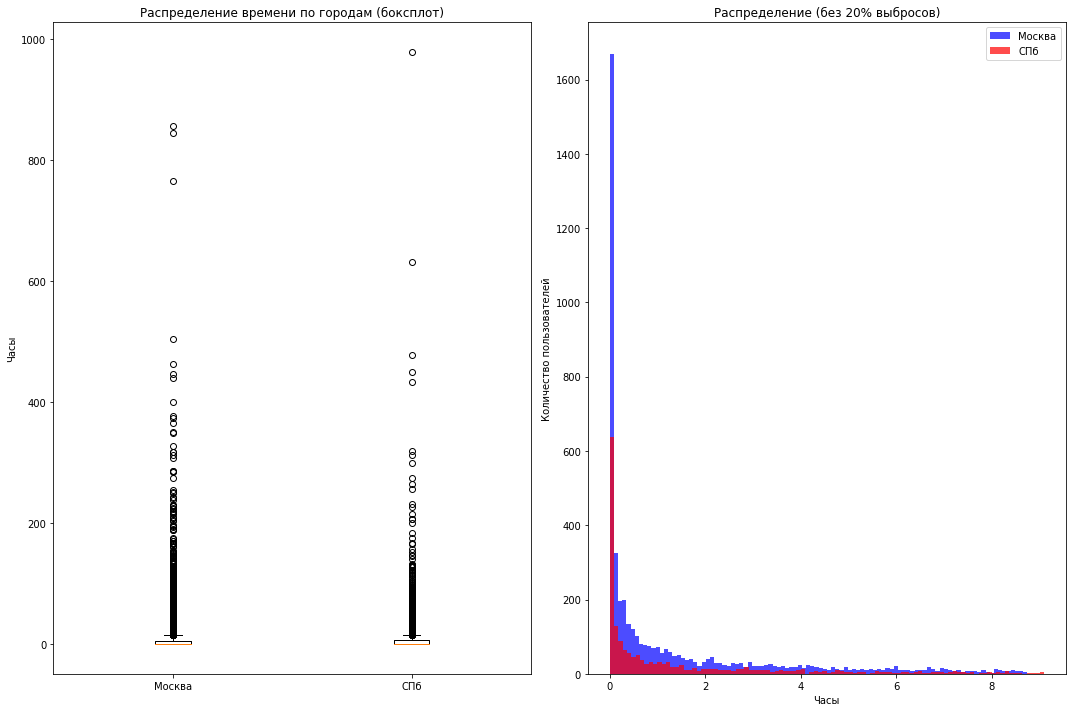

In [44]:
# Визуализируем распределения
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].boxplot([df_msc, df_spb], labels=['Москва', 'СПб'])
axes[0].set_title('Распределение времени по городам (боксплот)')
axes[0].set_ylabel('Часы')
# Убираем выбросы для лучшей визуализации
moscow_no_outliers = df_msc[df_msc < df_msc.quantile(0.8)]
spb_no_outliers = df_spb[df_spb < df_spb.quantile(0.8)]
print('Среднее значение часов, проведенных за чтением в Москве: ', round(moscow_no_outliers.mean(),2))
print('Среднее значение часов, проведенных за чтением в Санкт-Петербурге: ',round(spb_no_outliers.mean(),2))
axes[1].hist(moscow_no_outliers, bins=100, alpha=0.7, label='Москва', color='blue')
axes[1].hist(spb_no_outliers, bins=100, alpha=0.7, label='СПб', color='red')
axes[1].set_title('Распределение (без 20% выбросов)')
axes[1].set_xlabel('Часы')
axes[1].set_ylabel('Количество пользователей')
axes[1].legend()

plt.tight_layout()
plt.show()

По 1 графику можем увидеть, что кол-во часов в двух городах распределено примерно одинаково. Имеются выбросы. На 2 графике видно, что большинство пользователей читают и прослушивают книги примерно 1.5 часа.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [57]:
result = st.mannwhitneyu(df_spb, df_msc, alternative='greater')
alpha = 0.05
print(f'p_value = {result.pvalue:.2f}')
if result.pvalue > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')
print(f'Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается')

p_value = 0.45
Нулевая гипотеза находит подтверждение!
Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается


In [58]:
#!
# 1. Проверка нормальности распределения (тест Шапиро-Уилка)
p_m = shapiro(df_msc).pvalue
p_s = shapiro(df_spb).pvalue

print(f"p-значение для Москвы: {p_m:.4f}")
print(f"p-значение для СПб: {p_s:.4f}")

# 2. Выбор критерия
if p_m > 0.05 and p_s > 0.05:
    print("Обе выборки распределены нормально. Применяем t-test (с поправкой Уэлча)")
    stat, p = ttest_ind(df_spb, df_msc, equal_var=False, alternative='greater')
else:
    print("Хотя бы одна из выборок НЕ нормально распределена. Применяем U-test (Манна-Уитни)")
    stat, p = mannwhitneyu(df_spb, df_msc, alternative='greater')

print(f"p-значение выбранного теста: {p:.4f}")

p-значение для Москвы: 0.0000
p-значение для СПб: 0.0000
Хотя бы одна из выборок НЕ нормально распределена. Применяем U-test (Манна-Уитни)
p-значение выбранного теста: 0.4532


In [59]:
#!
avdd = st.ttest_ind(df_spb, df_msc, alternative='greater')
alpha = 0.10
print(f'p_value = {avdd.pvalue:.2f}')
if avdd.pvalue > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')
print(f'Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается')

p_value = 0.33
Нулевая гипотеза находит подтверждение!
Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается


Выводы двух тестов не расходятся.

## 3. Аналитическая записка

Ядро аудитории (75%): В обеих группах состоит из малоактивных пользователей.
Различие в "хвосте": Активность создается небольшим процентом активных пользователей. В группе СПБ этот "хвост" более "тяжелый" и неоднородный — есть несколько крайне активных пользователей, которые "тянут" на себе среднее значение и увеличивают общий разброс.

Мы провели статистический анализ и проверили гипотезу. Выбрали для работы U-тест Манна-Уитни. 
Уровень статистической значимости установили 5%. 
P-value = 0.45, что больше статистической значимости, а значит, мы не нулевую гипотезу.
Выяснили, что средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается!

----

# Часть 2. Анализ результатов A/B-тестирования

Задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Цели исследования.



Необходимо провести оценку результатов A/B-теста, оценить корректность проведения теста и проанализировать его результаты.
Проверим гипотезу: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

## 2. Загрузим данные, оценим их целостность.


In [3]:
participants = pd.read_csv('ab_test_participants.csv')
events = pd.read_csv('ab_test_events.zip', parse_dates=['event_dt'], low_memory=False)

Всего 14525 строк, пропусков нет, типы данных правильные.
- user_id — идентификатор пользователя;
- group — группа пользователя;
- ab_test — название теста;
- device — устройство, с которого происходила регистрация.

Всего 787286 строк, пропуски имеются в столбце details, типы данных правильные. Есть надписи 'GLOBAL' в идентификаторах пользователей.
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии.

In [4]:
print('Кол-во GLOBAL = ', events[events['user_id']=='GLOBAL']['user_id'].count())

Кол-во GLOBAL =  58495


## 3. По таблице `ab_test_participants` оценим корректность проведения теста:

   3\.1 Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [6]:
# Узнаем какие a/b тесты проводились, нас интересует interface_eu_test
print(participants['ab_test'].unique())

['interface_eu_test' 'recommender_system_test']


In [20]:
test_A = participants[participants['group']=='A']
test_B = participants[participants['group']=='B']
intersection_users = set(test_A['user_id']).intersection(set(test_B['user_id']))
print('Количество пересечений между группами А и В = ',len(intersection_users))

Количество пересечений между группами А и В =  446


In [21]:
test_eu = participants[participants['ab_test']=='interface_eu_test']
test_rec = participants[participants['ab_test']=='recommender_system_test']
intersection_users_test = set(test_eu['user_id']).intersection(set(test_rec['user_id']))
print('Количество пересечений между тестами= ',len(intersection_users_test))

Количество пересечений между тестами=  887


In [19]:
# Объединяем все проблемные user_id
problem_users = intersection_users.union(intersection_users_test)
# Фильтруем исходный датафрейм
test_clean = participants[~participants['user_id'].isin(problem_users)]

In [24]:
# Теперь оставим в таблице записи только с interface_eu_test
eu_test = test_clean[test_clean['ab_test']=='interface_eu_test']

In [25]:
#Посчитаем кол-во пользователей в каждой группе и сравним
test_group = eu_test.groupby('group')['user_id'].nunique()
test_A_count = test_group[0]
test_B_count = test_group[1]
print('Кол-во пользователей в контрольной группе: ', test_A_count)
print('Кол-во пользователей в тестовой группе: ',test_B_count)
perc_diff = 100*abs(test_B_count-test_A_count)/test_B_count
print(f'Процентная разница в количестве пользователей в группах control и test = {perc_diff:.2f}%')

Кол-во пользователей в контрольной группе:  4952
Кол-во пользователей в тестовой группе:  5011
Процентная разница в количестве пользователей в группах control и test = 1.18%


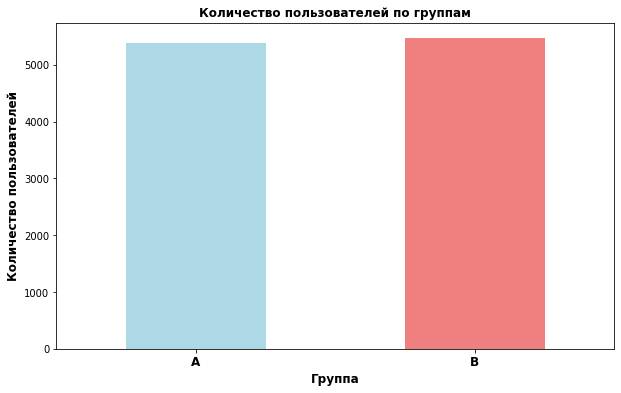

In [9]:
plt.figure(figsize=(10, 6))
test_group.plot.bar(color = ['lightblue','lightcoral'])
plt.title('Количество пользователей по группам', fontsize=12, fontweight='bold')
plt.ylabel('Количество пользователей', fontsize=12, fontweight='bold')
plt.xlabel('Группа', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.show()

3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- Оставляем только события, связанные с участвующими в изучаемом тесте пользователями.

In [26]:
test = eu_test.merge(events, on = 'user_id',how='left')

- Определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [27]:
# Находим дату регистрации для каждого пользователя
registration_dates = test[test['event_name'] == 'registration'].groupby('user_id')['event_dt'].min().reset_index()
registration_dates.columns = ['user_id', 'registration_dt']

# Объединяем даты регистрации с основным DataFrame
df_with_reg = test.merge(registration_dates, on='user_id', how='left')

# Рассчитываем лайфтайм (время от регистрации до события)
df_with_reg['lifetime'] = round((df_with_reg['event_dt'] - df_with_reg['registration_dt']).dt.total_seconds() / (24 * 3600)) # в днях

# Фильтруем события первых 7 дней
# Учитываем только события после регистрации (lifetime >= 0) и в пределах 7 дней (lifetime < 7)
filtered_events = df_with_reg[(df_with_reg['lifetime'] >= 0) & (df_with_reg['lifetime'] < 7)]
display(filtered_events)
# Проверяем результат
print(f"Всего событий в исходных данных: {len(test)}")
print(f"Событий в течение первых 7 дней после регистрации: {len(filtered_events)}")
print(f"Уникальных пользователей с событиями: {filtered_events['user_id'].nunique()}")

if len(filtered_events) > 0:
    lifetime_stats = filtered_events['lifetime'].describe()
    print("Статистика лайфтайма событий (в днях):", lifetime_stats)    
    print("Распределение событий по дням после регистрации:")
    day_distribution = filtered_events['lifetime'].astype(int).value_counts().sort_index()
    display(day_distribution)

,user_id,group,ab_test,device,event_dt,event_name,details,registration_dt,lifetime
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0.0
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0.0
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0.0
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0.0
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,2.0
...,...,...,...,...,...,...,...,...,...
73809,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:15,registration,0.0,2020-12-13 23:52:15,0.0
73810,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:22,login,NaN,2020-12-13 23:52:15,0.0
73812,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:37:34,registration,-0.45,2020-12-13 17:37:34,0.0
73813,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:56:02,login,NaN,2020-12-13 17:37:34,0.0


Всего событий в исходных данных: 73815
Событий в течение первых 7 дней после регистрации: 62730
Уникальных пользователей с событиями: 9963
Статистика лайфтайма событий (в днях): count    62730.000000
mean         1.268962
std          1.773007
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max          6.000000
Name: lifetime, dtype: float64
Распределение событий по дням после регистрации:


0    34263
1     8159
2     6469
3     4749
4     3645
5     2992
6     2453
Name: lifetime, dtype: int64

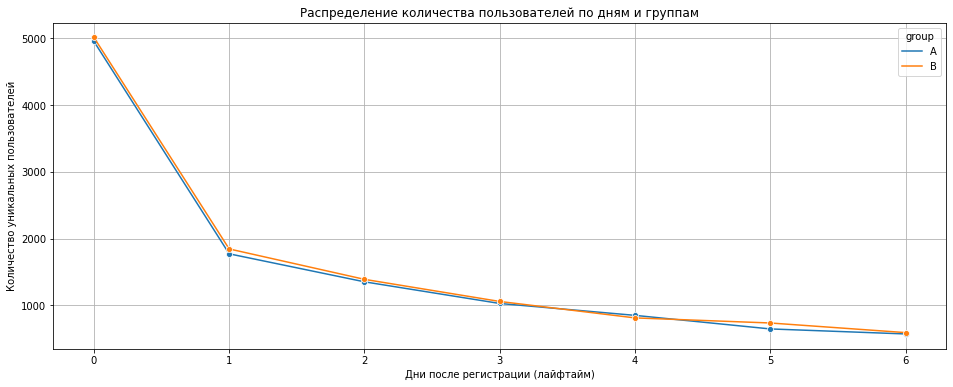

In [28]:
#Визуализируем
count_users_per_day = filtered_events.groupby(['lifetime','group'])['user_id'].nunique().reset_index()
plt.figure(figsize=(16, 6))
sns.lineplot(data=count_users_per_day, x='lifetime', y='user_id', hue='group', marker='o')
plt.xlabel('Дни после регистрации (лайфтайм)')
plt.ylabel('Количество уникальных пользователей')
plt.title('Распределение количества пользователей по дням и группам')
plt.grid(True)
plt.show()

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [29]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p1 = 0.3  # Базовая конверсия (из условий)
p2 = 0.33  # Целевая конверсия (p1 + 0.03)

effect_size = proportion_effectsize(p1, p2)

In [30]:
# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")
print(f"Общий необходимый размер выборки для каждой группы: {int(sample_size)*2}")

Необходимый размер выборки для каждой группы: 3761
Общий необходимый размер выборки для каждой группы: 7522


Кол-во данных таблицы хватает для проведения a/b теста.

Рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [31]:
print("Названия событий пользователей = ", filtered_events['event_name'].unique())

Названия событий пользователей =  ['registration' 'login' 'product_page' 'product_cart' 'purchase']


In [32]:
# Найдем пересечения между тестами, после того, как 
# оставили события, связанные с участвующими в изучаемом тесте пользователями
test_A_purchase = filtered_events[(filtered_events['group']=='A') & (filtered_events['event_name']=='purchase')]['user_id'].nunique()
test_B_purchase = filtered_events[(filtered_events['group']=='B') & (filtered_events['event_name']=='purchase')]['user_id'].nunique()
print("Всего пользователей в контрольной группе: ", test_A_count, "Только с покупкой: ",test_A_purchase, "Конверсия = ", round(test_A_purchase/test_A_count*1.0,2))
print("Всего пользователей в тестовой группе: ", test_B_count, "Только с покупкой: ",test_B_purchase, "Конверсия = ", round(test_B_purchase/test_B_count*1.0,2))

Всего пользователей в контрольной группе:  4952 Только с покупкой:  1342 Конверсия =  0.27
Всего пользователей в тестовой группе:  5011 Только с покупкой:  1444 Конверсия =  0.29


Можно заметить, что в тестовой группе кол-во покупок больше на 2%. Можно предположить, что упрощения интерфейса положительно повлияли на конверсию покупок, но не так сильно, как предполагалось.

## 4. Проведем оценку результатов A/B-тестирования:

- Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Нулевая гипотеза  𝐻0:
 
Конверсия покупок пользователей не изменилась при упрощении интерфейса.

Альтернативная гипотеза  𝐻1:
 
Конверсия покупок пользователей увеличилась при упрощении интерфейса как минимум на три процентных пункта.

In [34]:
from statsmodels.stats.proportion import proportions_ztest
n_a,n_b = test_A_count, test_B_count
m_a,m_b = test_A_purchase,test_B_purchase
p_a,p_b = m_a/n_a,m_b/n_b
alpha = 0.05
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha =  0.05

stat_ztest, p_value_ztest = proportions_ztest([m_b, m_a],[n_b, n_a], alternative='larger')

print(f'pvalue={p_value_ztest:.4f}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

print('Новая версия сайта увеличила конверсию покупок')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.0282
Нулевая гипотеза не находит подтверждения!
Новая версия сайта увеличила конверсию покупок


На основе проведенного анализа результатов A/B-теста можно сделать следующие выводы:

1. Корректность проведения теста
Тест проводился в соответствии с техническим заданием: пользователи были разделены на контрольную (A) и тестовую (B) группы для теста interface_eu_test.

Распределение пользователей по группам было практически равномерным:

Группа A: 4952 пользователя,

Группа B: 5011 пользователей.
Разница между группами составляет всего 1.18%.

Пересечений между группами теста не обнаружено: ни один пользователь не участвовал одновременно в обеих группах.

Данных достаточно для обеспечения статистической мощности теста: рассчитанный необходимый размер выборки для каждой группы — 3761 пользователь, что меньше фактического количества участников.

2. Результаты теста
Конверсия в покупку в течение 7 дней после регистрации составила:

Группа A (старый интерфейс): 27% (1342 из 4952 пользователей),

Группа B (новый интерфейс): 28% (1444 из 5011 пользователей).

Абсолютный прирост конверсии в группе B составил 2 процентных пункта (29% - 27% = 2%).

3. Проверка гипотезы
Нулевая гипотеза (H₀): Упрощение интерфейса не повлияло на конверсию.

Альтернативная гипотеза (H₁): Упрощение интерфейса увеличило конверсию как минимум на 3 процентных пункта.

Результат статистического теста:

P-value = 0.0282 (при уровне значимости α = 0.05).

Ожидаемый эффект: увеличение конверсии на 3 процентных пункта.

Фактический эффект: увеличение конверсии на 2 процентных пункта.

Вывод: Несмотря на статистическую значимость различий, ожидаемый эффект в 3 процентных пункта не достигнут. Новый интерфейс привел к улучшению конверсии, но не к целевым 3%.

5. Рекомендации
Внедрение нового интерфейса может быть целесообразным, так он показал статистически значимое улучшение конверсии. Однако его влияние оказалось ниже заявленных ожиданий.

Рекомендуется дополнительно изучить причины, почему эффект оказался слабее:

Возможно, изменения в интерфейсе были недостаточно радикальными.

Или требуются дополнительные улучшения (например, упрощение процесса оплаты или навигации).